In [1]:
!pip install transformers==4.33.0 --quiet
!pip install torch torchvision torchaudio --quiet
!pip install tqdm --quiet

import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from IPython.display import display
import cv2
import os
import numpy as np
from google.colab import drive

from transformers import (
    CLIPTokenizer,
    CLIPTextModelWithProjection,
    CLIPProcessor,
    CLIPModel
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.33.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s 

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# Functions


### Get Text Embedding

In [2]:
def get_text_embedding(texts, tokenizer, text_model, device="cpu", max_len=77):
    text_model.eval()
    inputs = tokenizer(
        text=texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        outputs = text_model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        text_embeds = outputs[0]

    text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
    return text_embeds

### Get Image Embedding

In [3]:
def precompute_image_embeddings(
    clip_model,
    image_processor,
    frames_folder,
    device="cpu",
    max_images=None
):
    clip_model.eval()

    all_files = os.listdir(frames_folder)
    jpg_files = [f for f in all_files if f.lower().endswith(".jpg")]
    jpg_files.sort()

    if max_images is not None:
        jpg_files = jpg_files[:max_images]

    embeddings_dict = {}

    for fname in tqdm(jpg_files, desc="Precomputing Image Embeddings"):
        path = os.path.join(frames_folder, fname)
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Error opening {fname}: {e}")
            continue

        inputs = image_processor(images=img, return_tensors="pt").to(device)

        with torch.no_grad():
            img_features = clip_model.get_image_features(**inputs)
            img_features = img_features / img_features.norm(dim=-1, keepdim=True)

        embeddings_dict[fname] = img_features.cpu()

    return embeddings_dict

### Retreive and Display images

In [4]:
def retrieve_topk_images(
    query,
    text_tokenizer,
    text_model,
    image_embeds_dict,
    device="cpu",
    top_k=5
):

    text_emb = get_text_embedding([query], text_tokenizer, text_model, device=device)

    similarities = []
    for fname, img_emb in image_embeds_dict.items():
        img_emb = img_emb.to(device)

        sim = torch.matmul(text_emb, img_emb.T).item()
        similarities.append((fname, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]


def display_topk_images(topk_results, frames_folder, size=(300, 300)):  # Resize to medium size
    for rank, (fname, sim) in enumerate(topk_results, start=1):
        print(f"Rank #{rank}, Similarity={sim:.4f}, File={fname}")
        img_path = os.path.join(frames_folder, fname)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            img = img.resize(size)  # Resize image to medium size
            display(img)
        else:
            print(f"Image not found: {img_path}")

### Extract Frames From Videos

In [5]:
def extract_frames_from_videos():
  video_folder = "/content/drive/My Drive/general videos"
  frames_folder = "/content/frames"

  os.makedirs(frames_folder, exist_ok=True)

  video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

  for video_file in video_files:
      video_path = os.path.join(video_folder, video_file)
      video_name = os.path.splitext(video_file)[0]

      cap = cv2.VideoCapture(video_path)
      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

      if total_frames < 5:
          print(f"Skipping {video_file} (less than 5 frames)")
          continue

      frame_indices = np.linspace(0, total_frames - 1, 5, dtype=int)

      for i, frame_idx in enumerate(frame_indices):
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
          success, frame = cap.read()
          if success:
              frame_filename = f"{video_name}_frame{i+1}.jpg"
              frame_path = os.path.join(frames_folder, frame_filename)
              cv2.imwrite(frame_path, frame)
          else:
              print(f"Failed to extract frame {frame_idx} from {video_file}")

      cap.release()

  print("Frame extraction completed!")

### search from our dataset

In [6]:
def search_from_our_dataset(prompt):
  image_embeds_dict = torch.load(EMBEDDINGS_PATH)

  topk = retrieve_topk_images(
      query=prompt,
      text_tokenizer=text_tokenizer,
      text_model=text_model,
      image_embeds_dict=image_embeds_dict,
      device=device,
      top_k=5
  )

  display_topk_images(topk, FRAMES_FOLDER)

# Compute embedding for given dataset


In [7]:
def compute_embedding_for_given_dataset():
  frames_folder = "/content/frames"  # Fix the path to match Colab

  if not os.path.exists(frames_folder):
      print("Error: The specified folder does not exist.")
  else:
      # Compute or load image embeddings
      embeddings_dict = precompute_image_embeddings(
          clip_model=clip_model,
          image_processor=image_processor,
          frames_folder=frames_folder,
          device=device,
          max_images=10000
      )

      print(f"\nComputed embeddings for {len(embeddings_dict)} images in {frames_folder}")
      return embeddings_dict


### search from given dataset


In [8]:
def search_from_given_dataset(prompt, embeddings_dict):
      frames_folder = "/content/frames"
      topk = retrieve_topk_images(
          query=prompt,
          text_tokenizer=text_tokenizer,
          text_model=text_model,
          image_embeds_dict=embeddings_dict,
          device=device,
          top_k=5
      )

      # Display results
      display_topk_images(topk, frames_folder)

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

MODEL_PATH = "/content/drive/MyDrive/saved_models/fine_tuned_model.pth"
FRAMES_FOLDER = "/content/drive/My Drive/ExtractedFrames_2"
EMBEDDINGS_PATH = "/content/drive/MyDrive/saved_models/my_image_embeddings.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

text_tokenizer = CLIPTokenizer.from_pretrained("Searchium-ai/clip4clip-webvid150k")
text_model = CLIPTextModelWithProjection.from_pretrained("Searchium-ai/clip4clip-webvid150k").to(device)

image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model      = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)

text_model.load_state_dict(checkpoint["text_model_state_dict"])
clip_model.load_state_dict(checkpoint["clip_model_state_dict"])

text_model.eval()
clip_model.eval()

print("Fine-tuned model loaded successfully!")

Mounted at /content/drive
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

Fine-tuned model loaded successfully!


# From msrvtt Dataset

<ipython-input-6-59a732a995d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeds_dict = torch.load(EMBEDDINGS_PATH)


Rank #1, Similarity=0.5209, File=video1381_frame_2.jpg


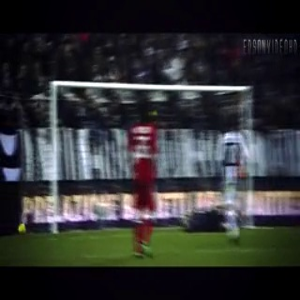

Rank #2, Similarity=0.5108, File=video1381_frame_1.jpg


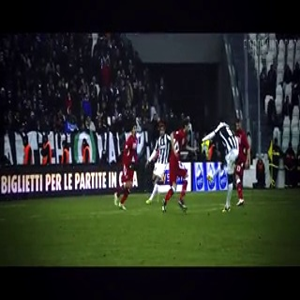

Rank #3, Similarity=0.5011, File=video3113_frame_2.jpg


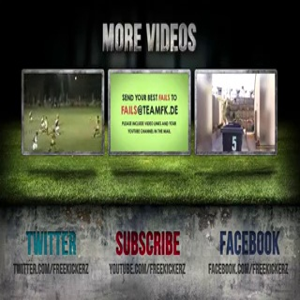

Rank #4, Similarity=0.4982, File=video3627_frame_1.jpg


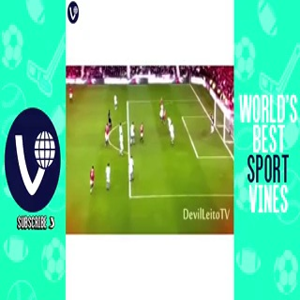

Rank #5, Similarity=0.4956, File=video2311_frame_2.jpg


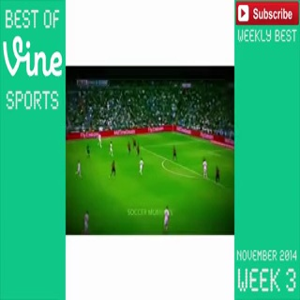

In [10]:
search_from_our_dataset("فوتبال")


<ipython-input-6-59a732a995d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeds_dict = torch.load(EMBEDDINGS_PATH)


Rank #1, Similarity=0.4734, File=video2104_frame_2.jpg


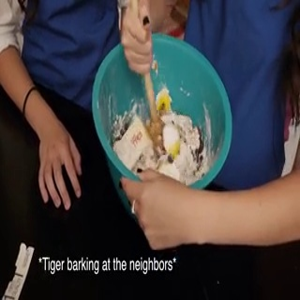

Rank #2, Similarity=0.4672, File=video359_frame_3.jpg


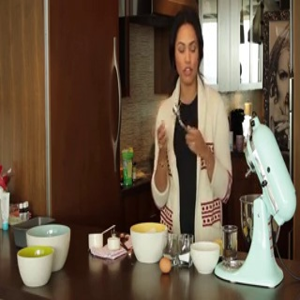

Rank #3, Similarity=0.4647, File=video1862_frame_2.jpg


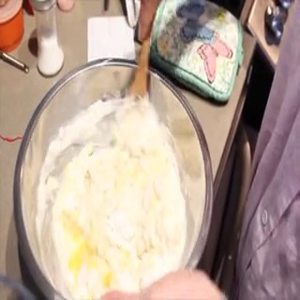

Rank #4, Similarity=0.4608, File=video3850_frame_2.jpg


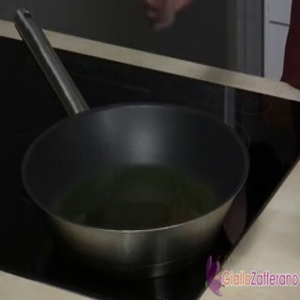

Rank #5, Similarity=0.4604, File=video1093_frame_3.jpg


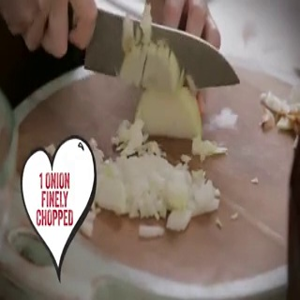

In [11]:
search_from_our_dataset("یک زن در حال آشپزی کردن ")

<ipython-input-6-59a732a995d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeds_dict = torch.load(EMBEDDINGS_PATH)


Rank #1, Similarity=0.5067, File=video3917_frame_2.jpg


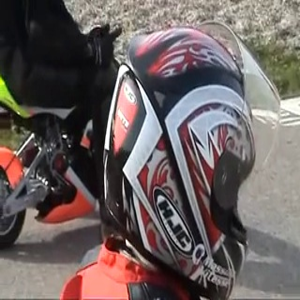

Rank #2, Similarity=0.4759, File=video3962_frame_3.jpg


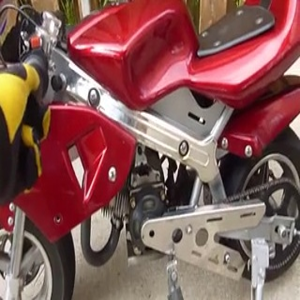

Rank #3, Similarity=0.4689, File=video3962_frame_1.jpg


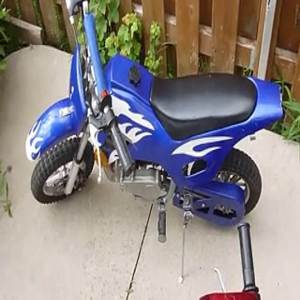

Rank #4, Similarity=0.4600, File=video125_frame_3.jpg


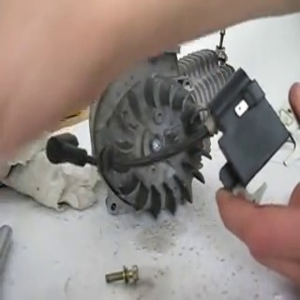

Rank #5, Similarity=0.4589, File=video3169_frame_3.jpg


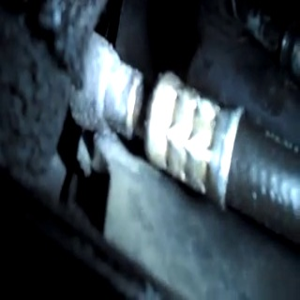

In [12]:
search_from_our_dataset("رانندگی موتور")


<ipython-input-6-59a732a995d0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeds_dict = torch.load(EMBEDDINGS_PATH)


Rank #1, Similarity=0.4940, File=video1479_frame_1.jpg


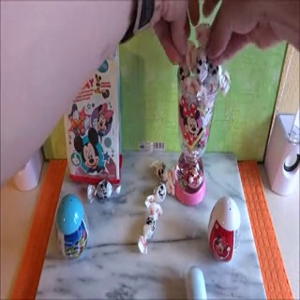

Rank #2, Similarity=0.4806, File=video1479_frame_3.jpg


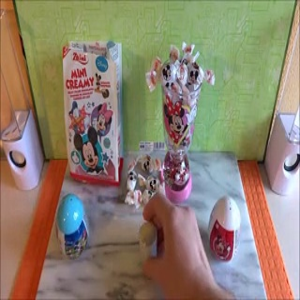

Rank #3, Similarity=0.4651, File=video1934_frame_3.jpg


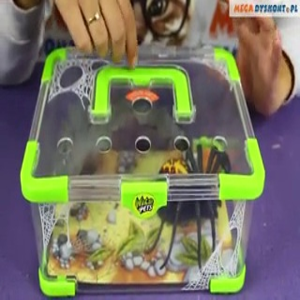

Rank #4, Similarity=0.4632, File=video3725_frame_3.jpg


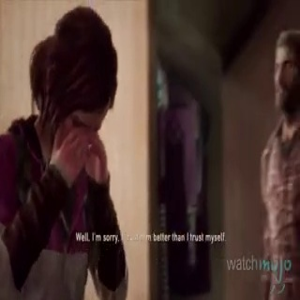

Rank #5, Similarity=0.4618, File=video1479_frame_2.jpg


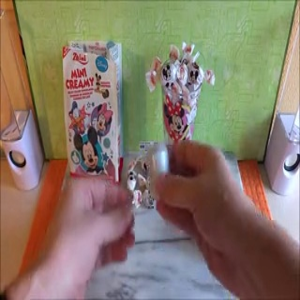

In [13]:
search_from_our_dataset("در حال بازی کردن")


# From given dataset

for using it make a folder in google drive named test_videos and put your videos in it

In [14]:
extract_frames_from_videos()

Frame extraction completed!


In [15]:
embeddings_dict = compute_embedding_for_given_dataset()

Precomputing Image Embeddings: 100%|██████████| 65/65 [00:19<00:00,  3.26it/s]


Computed embeddings for 65 images in /content/frames


Rank #1, Similarity=0.3706, File=generalVid11_frame5.jpg


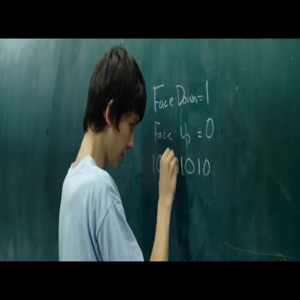

Rank #2, Similarity=0.3681, File=generalVid11_frame2.jpg


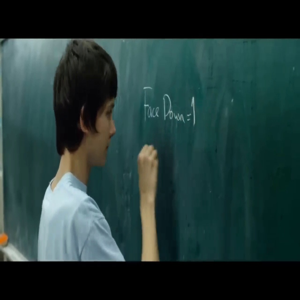

Rank #3, Similarity=0.2962, File=generalVid11_frame3.jpg


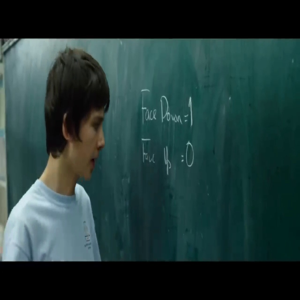

Rank #4, Similarity=0.2815, File=generalVid11_frame1.jpg


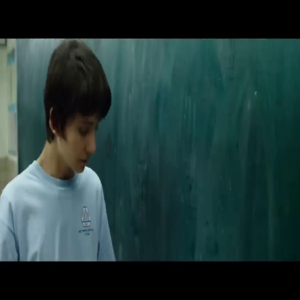

Rank #5, Similarity=0.2795, File=generalVid13_frame4.jpg


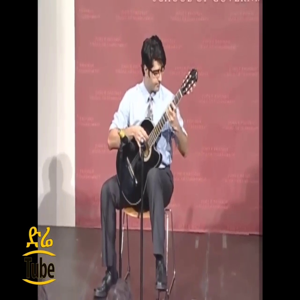

In [18]:
search_from_given_dataset("یک پسر که بر روی تخته در حال حل مسئله است", embeddings_dict)

Rank #1, Similarity=0.3515, File=generalVid5_frame1.jpg


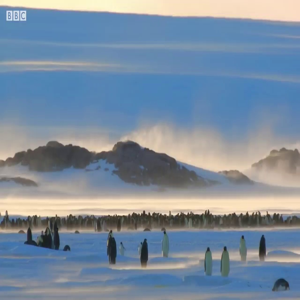

Rank #2, Similarity=0.3478, File=generalVid7_frame2.jpg


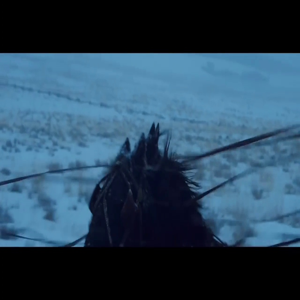

Rank #3, Similarity=0.3321, File=generalVid1_frame4.jpg


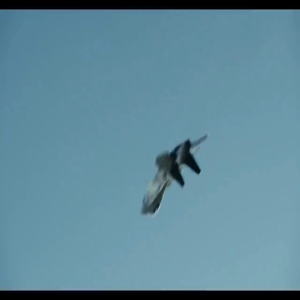

Rank #4, Similarity=0.3088, File=generalVid5_frame2.jpg


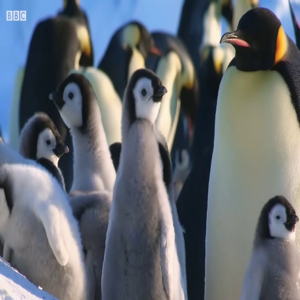

Rank #5, Similarity=0.2948, File=generalVid8_frame4.jpg


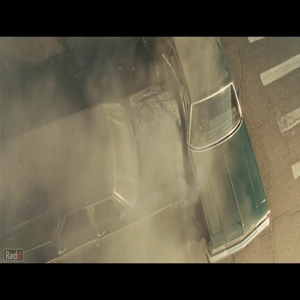

In [20]:
search_from_given_dataset("منظره ای از پنگوئن ها", embeddings_dict)